In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [ ]:
from baseline.coref_resolution import *

In [ ]:
vec, X, y, pairs = generate_data('../data/pwc_split_on_labeled/train.jsonl', 
                                '../data/pwc_split_on_labeled/dev.jsonl', 
                                '../data/pwc_split_on_labeled/test.jsonl')

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from yellowbrick.classifier import DiscriminationThreshold

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    lr = LogisticRegressionCV(class_weight="balanced", penalty="l2", scoring="f1", cv=5)
    lr.fit(X["train"], y["train"])

logging.info("Fitted Logistic Regression ..")

pred = lr.predict(X["dev"])

In [ ]:
pred_prob = lr.predict_proba(X["dev"])

In [ ]:
from dygie.training.thresholding_f1_metric import *

In [ ]:
metric = BinaryThresholdF1(bins=100)

In [ ]:
import torch

In [ ]:
p = torch.Tensor([pred_prob[:, 1]])
g = torch.Tensor(np.array([y["dev"]]))

In [ ]:
metric(p, g)

In [ ]:
precision = f1_metric._prf_divide(metric.matched_counts, metric.predicted_counts)
recall = f1_metric._prf_divide(metric.matched_counts, metric.total_counts)
f1 = f1_metric._prf_divide(2*precision*recall , (precision + recall))

In [ ]:
metric.get_metric(reset=False)

In [ ]:
plt.plot(precision)
plt.plot(recall)
plt.plot(f1)
plt.show()

In [ ]:
np.abs(precision - recall)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.metrics import *
from tqdm import tqdm

In [ ]:
precision, recall, f1 = [], [], []
pred_prob = lr.predict_proba(X['dev'])
for t in tqdm(np.linspace(0, 1, 100)) :
    pred = np.where(pred_prob[:, 1] > t, 1, 0)
    p, r, f, s = precision_recall_fscore_support(y['dev'], pred, average='binary')
    precision.append(p)
    recall.append(r)
    f1.append(f)

In [ ]:
plt.plot(precision, label="precision")
plt.plot(recall, label="recall")
plt.plot(f1, label="f1")
plt.legend()
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y["dev"], pred_prob[:, 1])

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
# plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
optimal_idx = np.argmax(tpr + (1 - fpr))
optimal_threshold = thresholds[optimal_idx]

In [ ]:
optimal_threshold

In [ ]:
tpr - fpr

In [ ]:
print(classification_report(y["dev"], pred_prob[:, 1] > 0.7))

In [ ]:
precision, recall, _ = precision_recall_curve(y['dev'], pred_prob[:, 1])
from inspect import signature

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [ ]:
import numpy.ma as ma

In [ ]:
a = ma.array(np.array([1, 2, 3]), mask=[0, 1, 0])
b = ma.array(np.array([2, 10, 100]), mask=[0, 0, 1])

In [ ]:
np.argmin(a/b)

In [ ]:
a/b

In [1]:
from dygie.data.dataset_readers.entity_linking_reader import PwCLinkerReader

In [3]:
pairs = PwCLinkerReader.generate_pairs('../data/pwc_split_on_labeled/dev.jsonl')

In [6]:
f = open('../data/pwc_split_on_labeled/dev_entity_pairs.jsonl', 'w')
import json
for p in pairs :
    f.write(json.dumps({"premise" : p[0], "hypothesis": p[1], "label" : p[2]}) + '\n')
f.close()

In [8]:
predictions = [json.loads(line) for 
               line in open('../outputs/pwc_outputs/experiment_linker/train_sampled/20190806-202943/dev_predict.jsonl')]

In [10]:
pred_labels = [x['label'] for x in predictions]

In [12]:
from sklearn.metrics import *

In [15]:
tn, fp, fn, tp = confusion_matrix([1 if x[2] == 'Entailment' else 0 for x in pairs], pred_labels).ravel()

In [38]:
examples = {(p, g):[] for p in range(2) for g in range(2)}

In [39]:
for i in range(len(pairs)) :
    p = pred_labels[i]
    g = 1 if pairs[i][2] == 'Entailment' else 0
    examples[(p, g)].append(pairs[i])

In [50]:
for i in range(len(examples[(1,1)])) : 
    e = examples[(1, 1)][i]
    if 'stanford' in e[0].lower() or 'stanford' in e[1].lower() :
        print(examples[(1, 1)][i])

In [2]:
import json

In [3]:
corefs = [json.loads(line) for line in open('../output_test_coref.json')]
ner = [json.loads(line) for line in open('../output_test.json')]

In [12]:
ner = {x['doc_id']:x for x in ner}

In [13]:
for d in corefs :
    ner[d['doc_id']]['coref_prediction'] = d['coref_prediction']

In [17]:
ex = list(ner.values())[0]

In [20]:
ex['coref_prediction']

[[[3644, 3645], [4449, 4452], 0.053],
 [[3644, 3645], [4558, 4559], 0.085],
 [[3644, 3645], [3743, 3747], 0.1],
 [[3644, 3645], [5717, 5718], 0.071],
 [[3644, 3645], [6166, 6167], 0.085],
 [[3644, 3645], [4636, 4637], 0.085],
 [[3644, 3645], [4591, 4594], 0.07],
 [[3644, 3645], [8499, 8501], 0.168],
 [[3644, 3645], [6904, 6905], 0.164],
 [[3644, 3645], [6242, 6243], 0.085],
 [[3644, 3645], [4309, 4310], 0.224],
 [[3644, 3645], [5527, 5528], 0.085],
 [[3644, 3645], [5044, 5045], 0.085],
 [[3644, 3645], [6101, 6104], 0.196],
 [[3644, 3645], [4079, 4081], 0.162],
 [[3644, 3645], [4415, 4417], 0.038],
 [[3644, 3645], [6544, 6547], 0.118],
 [[3644, 3645], [6390, 6391], 0.059],
 [[3644, 3645], [3847, 3850], 0.053],
 [[3644, 3645], [6497, 6501], 0.074],
 [[3644, 3645], [5725, 5726], 0.113],
 [[3644, 3645], [6931, 6932], 0.085],
 [[3644, 3645], [3861, 3863], 0.187],
 [[3644, 3645], [3983, 3985], 0.178],
 [[3644, 3645], [4086, 4088], 0.309],
 [[3644, 3645], [4222, 4225], 0.181],
 [[3644, 3645],

In [21]:
for k, v in ner.items() :
    v['prediction'] = {tuple(x['span']):x['label'] for x in v['prediction']}
    v['gold'] = {tuple(x['span']):x['label'] for x in v['gold']}
    v['coref_prediction'] = [(tuple(x[0]), tuple(x[1]), x[2]) for x in v['coref_prediction']]

In [24]:
span2idx = {k:i for i, k in enumerate(ex['prediction'])}

In [27]:
import numpy as np

In [28]:
mat = np.zeros((len(span2idx), len(span2idx)))

In [30]:
for e1, e2, f in ex['coref_prediction'] :
    mat[span2idx[e1], span2idx[e2]] = f

In [32]:
import matplotlib.pyplot as plt

<Figure size 2160x2160 with 0 Axes>

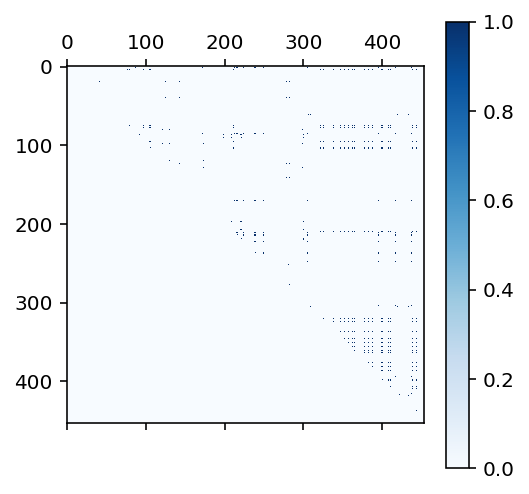

In [47]:
plt.figure(figsize=(30, 30))
plt.matshow((mat > 0.6).astype(float), cmap="Blues")
plt.colorbar()
plt.show()

In [55]:
from scripts.convert_predictions_to_brat import *

In [59]:
generate_brat_annotations(documents=ner, brat_anno_folder='../brat/data/result_extraction_results/ner')

100%|██████████| 16/16 [00:00<00:00, 76.35it/s]
